In [1]:
import PySO
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import matplotlib.animation as animation
import ffmpeg

In [2]:
def Rastrigin_func(params):
    '''

    Rastrigin function, flipped upside down (since we are searchinf for maxima), as a test function for hierarchical swarm optimization

    INPUTS:
    ------
    params: numpy array shape (#data_points, #dimensions)
        positions to evaluate the Rastrigin function on
        
    RETURNS:
    ------
    f: numpy array (#data_points,)
        Rastrigin function evaluated on all the positions provided
    '''
    f = -(10*params.shape[1]+np.sum(params**2-10*np.cos(2*np.pi*params),axis=1))
    return(f)

Visualising the function:

In [3]:
%matplotlib widget

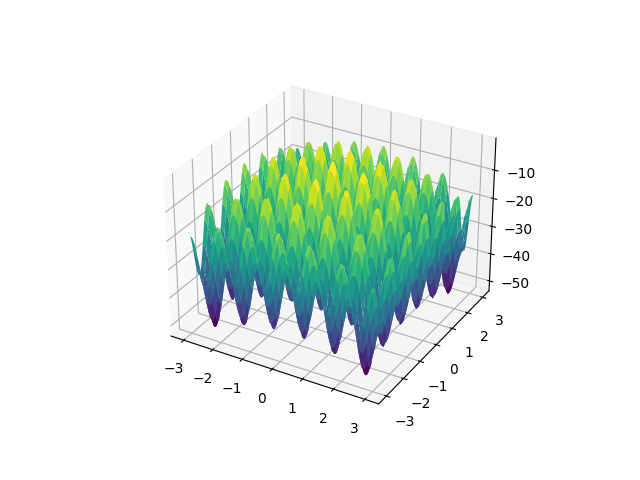

In [4]:
x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)

X, Y = np.meshgrid(x,y)

params = np.stack((X.flatten(),Y.flatten())).T
func_vals = Rastrigin_func(params).reshape(1000,1000)


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none')

plt.show()

In [5]:

import PySO

from albertos.custom_params import RedshiftedMass1RedshiftedMass2


class Tempered_PSO(PySO.Model):
    """
    Tempered Heirarchical likelihood PSO for the Rastrigin_function
    """
    names =['x','y']   
    
    
    # Hardcoded bounds for now 
    bounds   = [[-3,3],
                [-3,3]]
    
    def __init__(self,segment_number):
        
        # In the language of tempering, segment number corresponds roughly to the "temperature"
        self.segment_number = segment_number
        
        # At the lowest segment in this case just go back to the original function without tempering
        if self.segment_number == 1:
            self.log_likelihood = self.log_likelihood_final

    def log_likelihood(self, params):
        '''
        Tempered Rastrigin likelihood 
        '''
        parameters_array = np.array([params[key] for key in list(params.keys())])
        
        func_vals = -(10*len(parameters_array)+np.sum(parameters_array**2-10*np.cos(2*np.pi*parameters_array)))
        
        Semi_Co_Log_L = np.exp((func_vals)/self.segment_number)
        
        if Semi_Co_Log_L == -np.inf: print(params)

        return(Semi_Co_Log_L)
        
        
    def log_likelihood_final(self, params):
        '''
        Original Rastrigin likelihood
        '''
        parameters_array = np.array([params[key] for key in list(params.keys())])
        
        func_vals = -(10*len(parameters_array)+np.sum(parameters_array**2-10*np.cos(2*np.pi*parameters_array)))
        
        return(func_vals)
        

In [6]:
import os

NumParticles = 500

outdir = 'hierarchical_results/'

# models = [Tempered_PSO(i) for i in range(20,0,-5)]
# # Appending the original model at the end 
# models.append(Tempered_PSO(1))
models = [Tempered_PSO(20),Tempered_PSO(20),Tempered_PSO(15),Tempered_PSO(15),Tempered_PSO(10),Tempered_PSO(10),
          Tempered_PSO(5),Tempered_PSO(5),Tempered_PSO(1),Tempered_PSO(1)]
# These parameters are a "sensible" initial guess for now which lets us find some of the secondaries 
swarm_kwargs = {'Verbose':False, 'Nthreads':5 , 'Periodic':[0,0]}


Omega = [0.99,0.5,0.5,0.5,0.4,0.4,0.4,0.4,0.3,0.3]
PhiP = [1.5,0.7,0.7,0.6,0.6,0.5,0.5,0.5,0.5,0.4]
PhiG = [0.2,0.0,0.0,0.5,0.0,0.6,0.0,0.7,0.0,0.8]

# Go into the right rough region, dont be TOO clustered-> Cognitive only PSO maps out the peaks close in the right rough region, then normal PSO with more and 
#    more weight on the group aspect. 


Heirachial_Swarms = PySO.HierarchicalSwarmHandler(models,
                                                  1,
                                                  NumParticles,
                                                  Omega = Omega, 
                                                  PhiP = PhiP, 
                                                  PhiG = PhiG,
                                                  Swarm_kwargs= swarm_kwargs,
                                                  Output = outdir, 
                                                  nPeriodicCheckpoint=1,
                                                  Verbose=False,
                                                  SaveEvolution=True, 
                                                  Minimum_exploration_iterations=30,
                                                  Initial_exploration_limit=30,
                                                  Maximum_number_of_iterations_per_step=250,
                                                  kick_velocities=False, 
                                                  use_func_vals_in_clustering= False,
                                                  max_particles_per_swarm=90)

history_file = os.path.join(outdir, "EnsembleEvolutionHistory.dat")
if os.path.isfile(history_file): os.system('rm {}'.format(history_file))

Heirachial_Swarms.Run()



Stability number: 1.1400000000000001

 Swarm  0  reached stall condition, freezing

 All swarms stalled! Switching segments from  20  to  20
Reinitiating swarms with Omega:  0.5  PhiP:  0.7  PhiG:  0.0
Stability number: 1.15

 Swarm  2  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 All swarms stalled! Switching segments from  20  to  15


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.5  PhiP:  0.7  PhiG:  0.0
Stability number: 1.15


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  0  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 All swarms stalled! Switching segments from  15  to  15
Swarm  1  is over the maximum size per swarm, redistributing  8  Particles


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.5  PhiP:  0.6  PhiG:  0.5
Stability number: 0.95


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:339: VisibleDeprecationWarning: Creating an ndarray fro


 Swarm  2  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 All swarms stalled! Switching segments from  15  to  10


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.4  PhiP:  0.6  PhiG:  0.0
Stability number: 1.0999999999999999


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  5  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 All swarms stalled! Switching segments from  10  to  10


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.4  PhiP:  0.5  PhiG:  0.6
Stability number: 0.8499999999999999


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  2  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 All swarms stalled! Switching segments from  10  to  5


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.4  PhiP:  0.5  PhiG:  0.0
Stability number: 1.15


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  0  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 All swarms stalled! Switching segments from  5  to  5


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.4  PhiP:  0.5  PhiG:  0.7
Stability number: 0.7999999999999999


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/Clustering_Swarms.py:178: UserWarning: Removing 2 clusters with [4 6] particles 
  warning.warn(W)
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities 


 Swarm  4  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 All swarms stalled! Switching segments from  5  to  1


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.3  PhiP:  0.5  PhiG:  0.0
Stability number: 1.05


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  3  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 All swarms stalled! Switching segments from  1  to  1


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clustering_parameter_positions = np.array([np.take(self.frozen_swarms[swarm_index].Points,self.clustering_indices,axis=1) for swarm_index


Reinitiating swarms with Omega:  0.3  PhiP:  0.4  PhiG:  0.8
Stability number: 0.7


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_positions = np.array([self.frozen_swarms[swarm_index].Points for swarm_index
/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_particle_velocities = np.array([self.frozen_swarms[swarm_index].Velocities for swarm_index



 Swarm  3  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  0  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 All swarms stalled on the last model, finishing up!


/home/ADF/dxb792/Desktop/Balrog/PySO/PySO/HierarchicalSwarmHandler.py:552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_swarm_values = np.concatenate(np.array([self.frozen_swarms[swarm_index].Values for swarm_index in list(self.frozen_swarms.keys())]))


In [7]:
# Reading in the results file 

import pandas as pd
history_file = pd.read_csv('hierarchical_results/EnsembleEvolutionHistory.dat')
heirarchical_steps = np.unique(history_file['HierarchicalModelNumber'])
iterations = np.unique(history_file['IterationNumber'])


In [8]:
# Recomputing the Rastrigin function over a smaller domain corresponding to the PSO domain for visualisation in following animation

x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)

X, Y = np.meshgrid(x,y)

params = np.stack((X.flatten(),Y.flatten())).T
func_vals = Rastrigin_func(params).reshape(1000,1000)

In [9]:
# Pre processing the results file in prep for the aimation 

heirachial_subsets = []
heirachial_subset_iteration_limits = []
num_swarm_in_each_subset = []
colour_maps = []
for heirachial_model_counter in heirarchical_steps:
    
    # Seperating the results file by the different segment sections 
    heirachial_subset = history_file[history_file['HierarchicalModelNumber'] == heirachial_model_counter]
    heirachial_subsets.append(heirachial_subset)
    # Number of swarms in each segment section 
    num_swarm_in_each_subset.append(len(np.unique(heirachial_subset['swarm_number'])))
    # Iteration range for each segment section 
    heirachial_subset_iteration_limits.append([np.min(heirachial_subset['IterationNumber']),
                    np.max(heirachial_subset['IterationNumber'])])
    # Generate colour map for each segment with N (number of swarms) different colours 
    colour_maps.append(plt.cm.get_cmap('gist_rainbow',num_swarm_in_each_subset[-1]))

heirachial_subset_iteration_limits = np.array(heirachial_subset_iteration_limits)


In [10]:
## Animation

fig = plt.figure(figsize=(25,10))
ax_vertical = fig.add_subplot(121,projection='3d')
ax_vertical.view_init(azim=0, elev=90)
ax_side = fig.add_subplot(122,projection='3d')


def animate(iteration):
    # Find which segment we are in 
    heirachy_index = np.arange(heirachial_subset_iteration_limits.shape[0])[(iteration>=heirachial_subset_iteration_limits[:,0])
                                                            & (iteration<=heirachial_subset_iteration_limits[:,1])][0]
    
    
    # Plotting limits etc 
    ax_vertical.clear()
    ax_side.clear()
    
    ax_vertical.set_xlim(-3,3)
    ax_vertical.set_ylim(-3,3)
    ax_vertical.set_zlim(-52,0)
    
    # azimuthal angle rotation over time 
    ax_side.view_init(azim=45+iteration, elev=45)
    ax_side.set_xlim(-3,3)
    ax_side.set_ylim(-3,3)
    ax_side.set_zlim(-52,0)
    
    
    # Select colour map for corresponding segment 
    heirachical_colour_map = colour_maps[heirachy_index]
    
    fig.suptitle('Iteration: '+str(iteration)+' Number of swarms: '+str(num_swarm_in_each_subset[heirachy_index]))
    
    # On both plots, plot the surface we are trying to optimize
    ax_vertical.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none',alpha=0.2,zorder=0)
    ax_side.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none',alpha=0.3,zorder=0)
    
    # Pick the dataframe for the segment we are in 
    df = heirachial_subsets[heirachy_index]
    
    # Filter to current iteration 
    iteration_dataframe = df[df['IterationNumber'] == iteration]
        

    # For each swarm in this iteration (including frozen ones)
    for swarm_index in range(num_swarm_in_each_subset[heirachy_index]):
        
        # Filter to specific swarm 
        df = iteration_dataframe[iteration_dataframe['swarm_number'] == swarm_index]
         
        # Extract positions and calculate scatter function values 
        positions = np.array([df['x'].to_numpy(),df['y'].to_numpy()]).T
        scatter_func_vals= Rastrigin_func(positions)
        
        # Plot positions and values on both plots 
        ax_vertical.scatter(df['x'],df['y'],scatter_func_vals,color=heirachical_colour_map(swarm_index),s=25,zorder=1)
        ax_side.scatter(df['x'],df['y'],scatter_func_vals,color=heirachical_colour_map(swarm_index),s=25,zorder=1,
                        label='Swarm Number: '+str(swarm_index)+' Particles: ' + str(positions.shape[0]))
    
    plt.legend(loc=(1,0.9))    
    ax_vertical.axis('off')
    ax_side.axis('off')

ani = animation.FuncAnimation(fig, animate, interval=1, frames=np.max(iterations))
ani.save('hierarchical_results/animation_non_periodic.mp4', writer='ffmpeg',fps=5)
plt.close()

In [11]:
%reset -f 